In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from scipy import stats
import math

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [88]:
df_calls = pd.read_csv('../cotton/data/df_cotton_on_call_contracts.csv').rename(columns={'futures_contract':'contract_code'})
df_prices = pd.read_csv('../cotton/data/df_cotton_prices.csv').rename(columns={'a_index':'price'})
df_futures = pd.read_csv('../cotton/data/df_cotton_futures.csv')
df_cotton_futures = df_futures[(df_futures.contract_code.apply(lambda x: x.startswith('CT'))) & (df_futures.contract_code!='CTY00')]
df_spot_price = df_futures[df_futures.contract_code == 'CTY00'].rename(columns={'open':'price'})

In [89]:
df_max_interest = df_cotton_futures.groupby('date').open_interest.max().reset_index()
df_futures_prices = df_cotton_futures.merge(df_max_interest, on=['date', 'open_interest'], how='inner').sort_values('date')
df_futures_prices = df_futures_prices[['date', 'close']].rename(columns={'close':'price'})

<Axes: xlabel='date'>

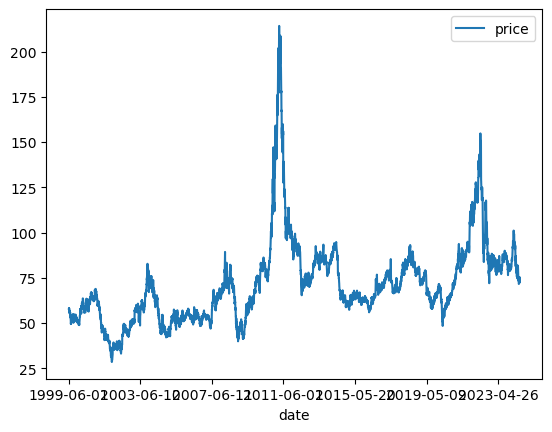

In [90]:
df_futures_prices.sort_values('date').plot(x='date', y='price')

<Axes: xlabel='date'>

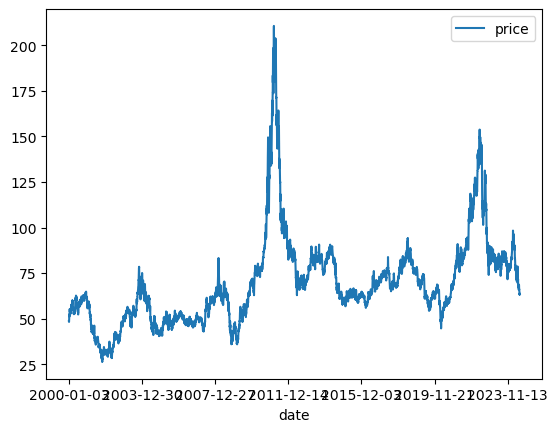

In [91]:
df_spot_price.sort_values('date').plot(x='date', y='price')

In [92]:
def add_cyclical_features(df, datetime_var, period, start_num=0):
    
    values = 2 * np.pi * (df[datetime_var] - start_num) / period
    kwargs = {f'sin_{datetime_var}': lambda x: np.sin(values),
              f'cos_{datetime_var}': lambda x: np.cos(values)}
    
    return df.assign(**kwargs)

In [155]:
class OnCallPrep:
    
    def __init__(self, df_calls):
        
        self.df_calls = df_calls.copy()
        
        self._create_misc_vars()

    def _create_misc_vars(self):
        
        self.df_calls = self.df_calls.rename(columns={'unfixed_purchase': 'purchase', 'unfixed_sale': 'sale'})
        
        self.df_calls['net'] = self.df_calls['sale'] - self.df_calls['purchase']
        self.df_calls['total'] = self.df_calls['sale'] + self.df_calls['purchase']
        # If no sales or purchases, make proportion equal (0.5), avoiding the division by 0
        self.df_calls['prop'] = np.where(self.df_calls['total'] == 0, 0.5, self.df_calls['sale'] / self.df_calls['total'])
        self.df_calls['report_month'] = pd.to_datetime(self.df_calls['date']).dt.month
        self.df_calls['report_year'] = pd.to_datetime(self.df_calls['date']).dt.isocalendar().year
        self.df_calls['futures_datetime'] = pd.to_datetime(self.df_calls['month'])
        self.df_calls['futures_month'] = pd.to_datetime(self.df_calls['month']).dt.month
        self.df_calls['futures_year'] = pd.to_datetime(self.df_calls['month']).dt.isocalendar().year
        self.df_calls['report_year_check'] = self.df_calls['date'].apply(lambda date: int(str(date)[0:4]))
        
        n_mismatches = self.df_calls[self.df_calls['report_year'] != self.df_calls['report_year_check']].shape[0]
        if n_mismatches > 0:
            # Weirdest bug ive ever seen
            print(f'Warning: pd.to_datetime has failed to convert the year properly in {n_mismatches} rows')
            self.df_calls['report_year'] = np.where(self.df_calls['report_year_check'] != self.df_calls['report_year'], self.df_calls['report_year_check'], self.df_calls['report_year'])

        self.df_calls['futures_month_ranked'] = self.df_calls.groupby('date')['futures_datetime'].rank(method='dense')
        
        self.df_calls = self._define_seasons(self.df_calls)
        
    def _define_seasons(self, df):
        
        df['season'] = np.where(df['report_month'] <= 7,
                            np.where(df['futures_month'] < 10,  
                                    np.where(df['report_year'] == df['futures_year'], 'season1',  
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season3', 'seasonOTHER'))),
                                np.where(df['report_year'] == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season3', 'seasonOTHER'))),
                            np.where(df['futures_month'] < 10,  
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season1',  
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 3 == df['futures_year'], 'season3', 'seasonOTHER'))),
                                np.where(df['report_year'] == df['futures_year'], 'season1', 
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season3', 'seasonOTHER'))))) 
        
        assert df[df.season=='seasonOTHER'].shape[0] == 0, 'Seasons incorrectly classified'
                                             
        return df
    
    def _create_call_features(self, df_calls, var):

        df_call_months = df_calls.pivot_table(index=['date', 'report_week', 'report_month'], columns='futures_month_ranked', 
                                              values=var, aggfunc='first').reset_index()
        df_call_months = df_call_months.rename(columns={x: f'{var}_calls_month_' + str(int(x)) for x in df_call_months.columns if x not in ['date', 'report_week', 'report_month']})
        
        features = sorted([x for x in df_call_months.columns if f'{var}_calls_month_' in x])
        
        df_call_months[f'{var}_total_calls'] = df_call_months[features].sum(axis=1)
        df_call_months[f'{var}_sum_next_2_calls'] = df_call_months[features[0:2]].sum(axis=1)
        df_call_months[f'{var}_sum_next_3_calls'] = df_call_months[features[0:3]].sum(axis=1)
        df_call_months[f'{var}_sum_next_4_calls'] = df_call_months[features[0:4]].sum(axis=1)
        df_call_months[f'{var}_sum_following_4_calls'] = df_call_months[features[4:8]].sum(axis=1)
        
        df_features = df_call_months.copy()
#         df_yearweek_total_calls_s1 = df_calls[df_calls.season=='season1']\
#                                           .groupby(['date', 'report_week', 'report_month'])[var].sum()\
#                                           .reset_index().rename(columns={var:f'{var}_total_calls_season1'})
#         df_yearweek_total_calls_s2 = df_calls[df_calls.season=='season2']\
#                                           .groupby(['date', 'report_week', 'report_month'])[var].sum()\
#                                           .reset_index().rename(columns={var:f'{var}_total_calls_season2'})
        
#         df_features = df_call_months.merge(df_yearweek_total_calls_s1, on=['date', 'report_week', 'report_month'], how='left')\
#                                     .merge(df_yearweek_total_calls_s2, on=['date', 'report_week', 'report_month'], how='left')
        
        ignore_cols = ['date', 'report_week', 'report_month']
        ignore_cols = ignore_cols + [x for x in df_features.columns if 'month_7' in x or 'month_8' in x]
        for feat in [col for col in df_features.columns if col not in ignore_cols]:
            for n_weeks in [1, 2, 4, 8, 12, 24, 52]:
                df_features[feat + f'_{n_weeks}weeks_ago'] = df_features[feat].shift(n_weeks)
                df_features[feat + f'_pct_share_{n_weeks}week'] = np.where(df_features[feat + f'_{n_weeks}weeks_ago'] + df_features[feat] == 0, 0.5,
                                                                            df_features[feat] / (df_features[feat + f'_{n_weeks}weeks_ago'] + df_features[feat]))
        
        feat = f'{var}_total_calls'
        for n_years in [3, 5, 10]:
            df_features = self._create_previous_year_comparisons_for_report_week(df_features, feat, n_years)
        
        return df_features
    
    def _create_previous_year_comparisons_for_report_week(self, df, feat, n_years):
        
        execution_string = f"df['{feat}_last{n_years}_total'] = df['{feat}']"
        
        for year in range(1, n_years + 1):
            execution_string += f" + df.groupby('report_week')['{feat}'].shift({year})"
        
        exec(execution_string)
        
        # if total value calculated in string execution above is 0, the share of the current week is 1 / n_years
        # For example, if looking back 5 years, if total is 0 (all years have 0 for the given week) then they all have a proportion of 1 / 5 = 0.2
        if_zero_value = 1 / n_years
        df[f'{feat}_last{n_years}_share'] = np.where(df[f'{feat}_last{n_years}_total'] == 0, 
                                                    if_zero_value, 
                                                    df[feat] / df[f'{feat}_last{n_years}_total'])
        
        return df
        
    def create_features(self):
        
        df_features_sale = self._create_call_features(self.df_calls, 'sale')
        df_features_purchase = self._create_call_features(self.df_calls, 'purchase')
        df_features_net = self._create_call_features(self.df_calls, 'net')
        df_features_net_prop = self._create_call_features(self.df_calls, 'prop')
        
        df_features = df_features_sale.merge(df_features_purchase, on=['date', 'report_week', 'report_month'], how='outer')\
                                      .merge(df_features_net, on=['date', 'report_week', 'report_month'], how='outer')\
                                      .merge(df_features_net_prop, on=['date', 'report_week', 'report_month'], how='outer')
        
        self.df_features = add_cyclical_features(df_features, 'report_week', 52, 1)

    def build_outcomes(self, df_in, var, datetime_var, n_forward_looks = [1, 2, 3, 5, 10]):

        df = df_in[[datetime_var, var]].sort_values(datetime_var).reset_index(drop=True).copy()
        
        for n in n_forward_looks:
            df[f'max_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=None, closed='left')[var]
                    .max()
                    .iloc[::-1])

            df[f'mean_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=None, closed='left')[var]
                    .mean()
                    .iloc[::-1])
            
            df[f'median_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=None, closed='left')[var]
                    .median()
                    .iloc[::-1])
            
            df[f'value_delta_median_{n}_forward'] = df[f'median_{n}_forward'] - df[var]
            df[f'value_delta_mean_{n}_forward'] = df[f'mean_{n}_forward'] - df[var]
            df[f'value_delta_max_{n}_forward'] = df[f'max_{n}_forward'] - df[var]
            
            df[f'pct_delta_median_{n}_forward'] = (df[f'median_{n}_forward'] / df[var]) - 1
            df[f'pct_delta_mean_{n}_forward'] = (df[f'mean_{n}_forward'] / df[var]) - 1
            df[f'pct_delta_max_{n}_forward'] = (df[f'max_{n}_forward'] / df[var]) - 1   
            
            df[f'binary_median_rise_{n}_forward'] = np.where(df[f'pct_delta_median_{n}_forward'] > 0, 1, 0)
            df[f'binary_mean_rise_{n}_forward'] = np.where(df[f'pct_delta_mean_{n}_forward'] > 0, 1, 0)
            df[f'binary_max_rise_{n}_forward'] = np.where(df[f'pct_delta_max_{n}_forward'] > 0, 1, 0)

            # These values are highly correlated with calls variables, because they are higly correlted with the price at the given time.
            # The high correlation, along with price itself, only tells us that there are many unfixed purchases when prices are low and
            # fewer when prices are high. If we were to use the on-call variables which correlate highly with these, we would just be learning 
            # that when there are high unfixed calls, the price is likely to be low, rather than learning whther the price is likely to
            # increase from here
            df = df.drop(columns=[f'max_{n}_forward', f'mean_{n}_forward', f'median_{n}_forward'])

        return df.drop(columns=var)
    
    def merge_outcomes(self, df_prices, n_forward_looks):
        
        self.df_outcomes = self.build_outcomes(df_prices, var='price', datetime_var='date', n_forward_looks=n_forward_looks)
        
        shape = self.df_features.shape[0]
        self.df_mset = self.df_features.merge(self.df_outcomes, on='date', how='inner')
        if self.df_mset.shape[0] < shape:
            print(f'Warning: Dropped {shape - self.df_mset.shape[0]} rows where no outcomes are available')
        
    def upload(self, filepath):
        
        self.df_mset.to_csv(filepath, index=False)

In [156]:
prep = OnCallPrep(df_calls)
prep.create_features()
prep.merge_outcomes(df_futures_prices, n_forward_looks=[30, 60, 90, 120])
prep.upload('../cotton/data/df_on_call_modelset.csv')
df_mset = prep.df_mset.copy()

In [158]:
# vars = ['date', 'purchase_total_calls_season1', 'purchase_total_calls_season1_12weeks_ago', 'purchase_total_calls_season1_pct_share_12week']
# df_mset[df_mset.purchase_total_calls_season1_pct_share_12week.isnull()][vars]

In [160]:
df_mset.isnull().sum().sort_values()

date                                   0
net_sum_next_4_calls                   0
net_sum_next_3_calls                   0
net_sum_next_2_calls                   0
net_total_calls                        0
                                    ... 
net_total_calls_last10_total         498
net_total_calls_last10_share         498
sale_total_calls_last10_share        498
sale_total_calls_last10_total        498
purchase_total_calls_last10_total    498
Length: 733, dtype: int64

In [161]:
outcome_vars = [x for x in prep.df_outcomes if x not in ['date', 'price']]
correlation_vars = [x for x in df_mset.columns if x not in ['date', 'report_month']]
feat_vars = [x for x in correlation_vars if x not in outcome_vars]
df_corr = df_mset[correlation_vars].corr()
df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_max_120_forward')
df_corr.style.background_gradient(cmap='coolwarm')

<Axes: xlabel='sale_total_calls_pct_share_52week', ylabel='value_delta_mean_120_forward'>

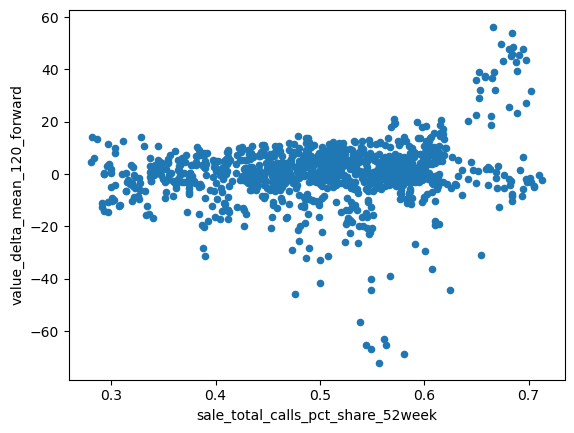

In [62]:
df_mset.plot(kind='scatter', x='sale_total_calls_pct_share_52week', y='value_delta_mean_120_forward')

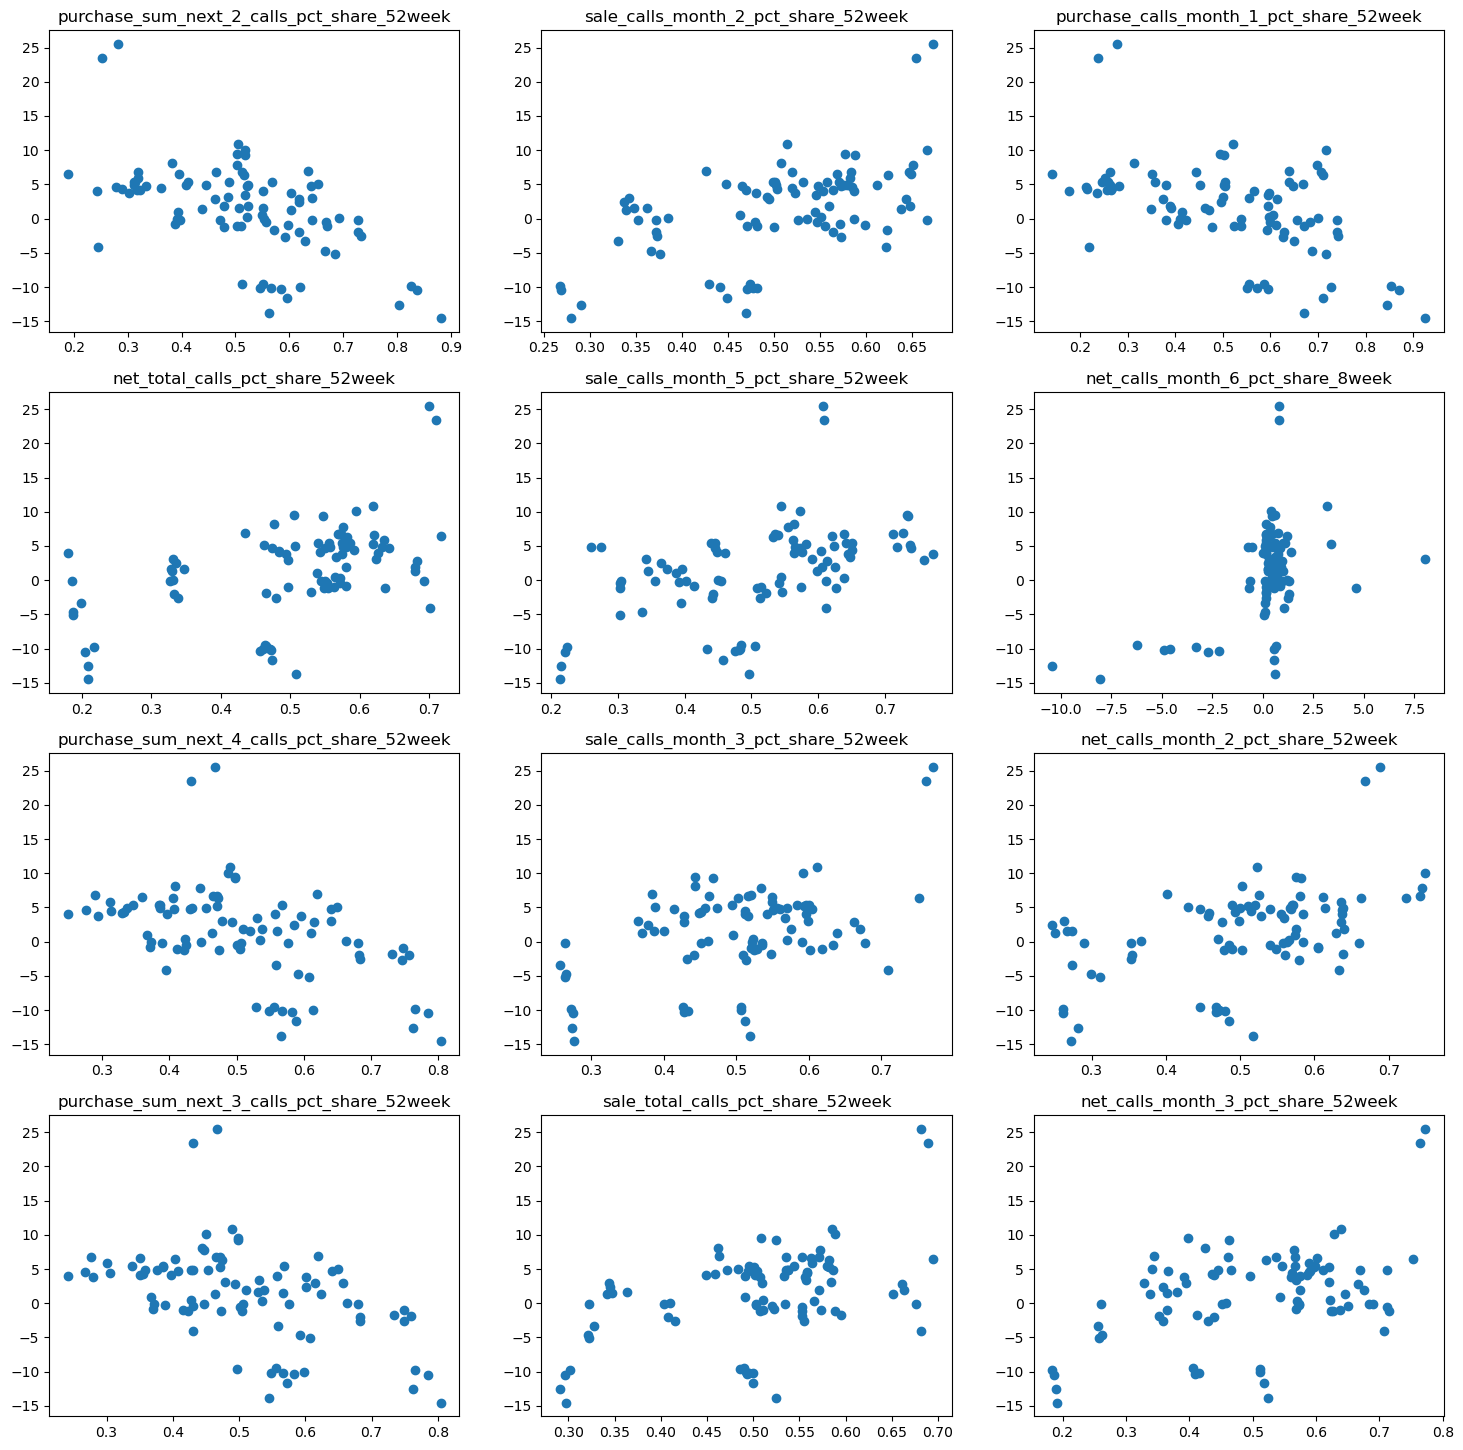

In [307]:
class Correlations:
    
    def __init__(self, df_mset, feat_vars, outcome):
        
        self.df_mset = df_mset
        self.feat_vars = feat_vars
        self.outcome = outcome
        
        self.correlation_vars = feat_vars + [outcome]
        
        self.df_corr = self.df_mset[self.correlation_vars].corr()
        self.df_corr = self.df_corr.drop([self.outcome], axis=0)[[self.outcome]].sort_values(self.outcome)
    
    def monthly_correlations(self):
        
        correlations = []

        for month in self.df_mset['report_month'].unique():
            df_corr = self.get_month_correlations(month, outcome)
            correlations.append(df_corr)
            
        self.df_monthly_corrs = pd.concat(correlations)
            
    def get_month_correlations(self, month, top_n=5):
        
        if month == 'all':
            df = self.df_mset.copy()
        elif isinstance(month, list):
            df = self.df_mset[self.df_mset['report_month'].isin(month)].copy()
        else:
            df = self.df_mset[self.df_mset['report_month'] == month].copy()
        
        df_corr = df[self.correlation_vars].corr()
        df_corr = df_corr.drop(self.outcome, axis=0)[self.outcome]\
                         .reset_index().rename(columns={'index':'feat'})
        
        df_corr['abs_corr'] = abs(df_corr[self.outcome])
        df_corr = df_corr.sort_values('abs_corr', ascending=False)
        df_corr_top = df_corr.iloc[0:top_n].copy()
        
        for i, row in df_corr_top.iterrows():
            feat = row['feat']
            null_prop = df[df[feat].isnull()].shape[0] / df.shape[0]
            df_corr_top.loc[i, 'null_prop'] = null_prop
        
        return df_corr_top, df
    
    def plot_correlations(self, month, top_n=6, n_per_row=3, figsize=(15, 7)):
        
        df_corr, df_month = self.get_month_correlations(month, top_n=top_n)
        
        n_rows = math.ceil(top_n / n_per_row)
        _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
        
        for feat, ax in zip(df_corr['feat'].values, axs.flatten()):
            ax.scatter(df_month[feat], df_month[self.outcome]) 
            ax.set_title(feat)             
             
                                   
corr = Correlations(df_mset, feat_vars, 'value_delta_mean_120_forward')
corr.plot_correlations(month=1, top_n=12, figsize=(18, 18))                         

In [37]:
corr = Correlations(df_mset, feat_vars, 'value_delta_mean_120_forward')
df_corr, df_month = corr.get_month_correlations(month=[2], top_n=24)

df_corr

,feat,value_delta_mean_120_forward,abs_corr,null_prop
282,purchase_total_calls_pct_share_24week,-0.535186,0.535186,0.041237
669,prop_total_calls_season1_24weeks_ago,-0.402477,0.402477,0.051546
611,prop_calls_month_6_12weeks_ago,0.397911,0.397911,0.041237
284,purchase_total_calls_pct_share_52week,-0.394398,0.394398,0.072165
593,prop_calls_month_5_4weeks_ago,0.391058,0.391058,0.041237
641,prop_sum_next_4_calls_24weeks_ago,-0.366916,0.366916,0.041237
8,sale_calls_month_8,-0.357246,0.357246,0.000000
64,sale_calls_month_4_12weeks_ago,-0.354224,0.354224,0.041237
525,prop_calls_month_6,0.353773,0.353773,0.000000
332,purchase_total_calls_season2_pct_share_4week,0.352207,0.352207,0.041237


In [179]:
df_modelset = df_mset.copy()
df_modelset = df_modelset[df_modelset.value_delta_mean_120_forward.notnull()].copy()
df_modelset = df_modelset.reset_index()

In [193]:
feat_vars = list(set(feat_vars + ['report_month']))
feat_vars = [x for x in feat_vars if 'last10' not in x and 'last5' not in x and 'month_8' not in x]

In [181]:
df_modelset[feat_vars].isnull().sum().sort_values()

prop_calls_month_7                    0
sale_sum_next_2_calls                 0
purchase_sum_following_4_calls        0
purchase_calls_month_1                0
net_sum_next_3_calls                  0
                                   ... 
net_total_calls_last3_total         150
prop_total_calls_last3_share        150
sale_total_calls_last3_total        150
purchase_total_calls_last3_total    150
prop_total_calls_last3_total        150
Length: 676, dtype: int64

In [182]:
df_modelset = df_modelset[df_modelset.prop_total_calls_last3_share.notnull()]
df_modelset[feat_vars].isnull().sum().sort_values()

purchase_sum_next_4_calls_2weeks_ago      0
sale_calls_month_1_pct_share_24week       0
prop_calls_month_1_pct_share_4week        0
purchase_calls_month_3_24weeks_ago        0
net_calls_month_4_24weeks_ago             0
                                         ..
net_sum_next_4_calls                      0
prop_calls_month_5_24weeks_ago            0
prop_calls_month_2_pct_share_2week        0
net_calls_month_3_24weeks_ago             0
purchase_calls_month_5_pct_share_1week    0
Length: 676, dtype: int64

In [267]:
period_var = 'index'
cut_point = (df_modelset[period_var].max() - df_modelset[period_var].min())*0.8 + df_modelset[period_var].min()
df_train = df_modelset[df_modelset[period_var] < cut_point].sort_values(period_var).copy()
df_test = df_modelset[df_modelset[period_var] >= cut_point].sort_values(period_var).copy()

In [198]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(df_train[feat_vars])

PCA(n_components=4)

In [199]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.60169575 0.12229677 0.05840718 0.03598641]
[5121609.53295652 2309008.2260527  1595699.49439129 1252527.38141166]


PCR r-squared -0.055


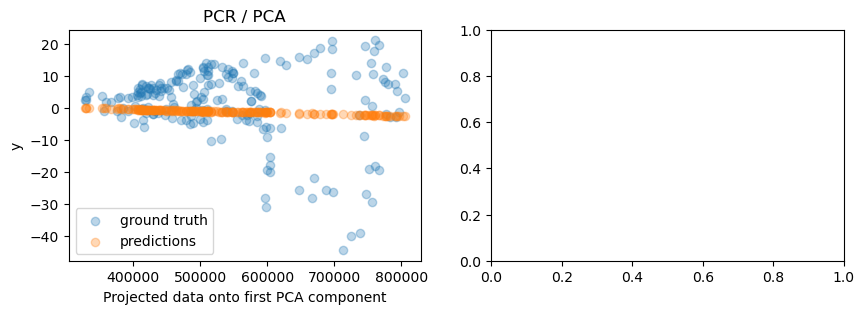

In [309]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, explained_variance_score, r2_score


X_train, y_train = df_train[feat_vars], df_train['value_delta_mean_120_forward']
X_test, y_test = df_test[feat_vars], df_test['value_delta_mean_120_forward']

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()

PLS train r-squared 0.315
PLS train explained_variance_score 0.315
PLS test r-squared -0.152
PLS test explained_variance_score 0.049


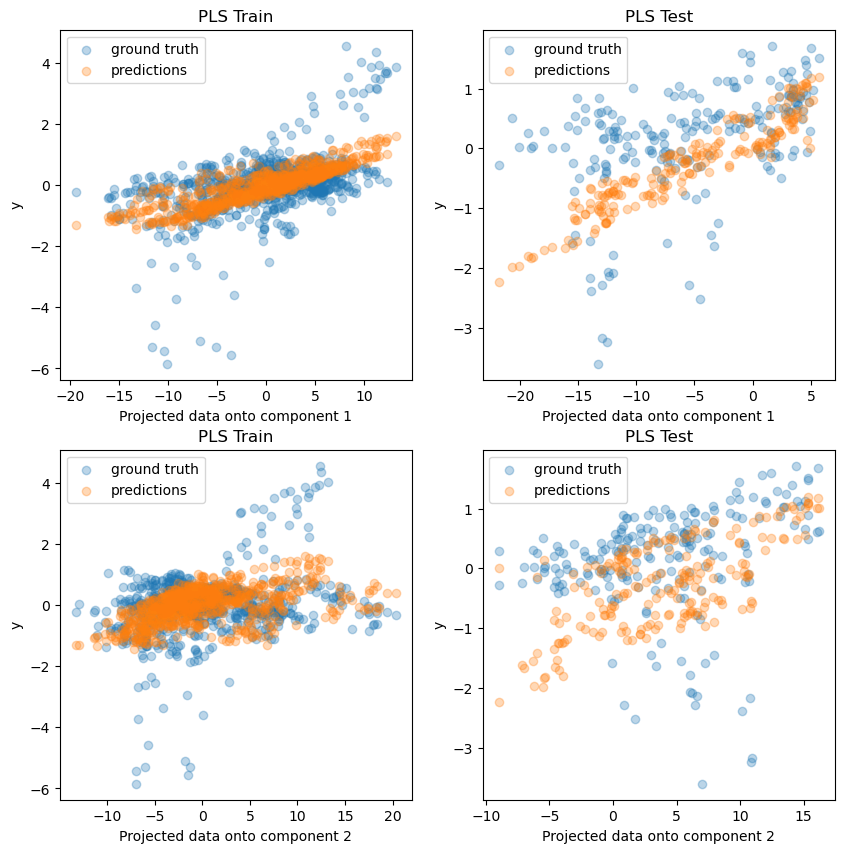

In [318]:
n_components = 2
outcome = 'value_delta_mean_120_forward'
month = 'all'

scaler = StandardScaler()

if month == 'all':
    df_train_month = df_train.copy()
    df_test_month = df_test.copy()
else:
    df_train_month = df_train[df_train.report_month == month]
    df_test_month = df_test[df_test.report_month == month]

scaler.fit(df_train_month[feat_vars + [outcome]])

df_train_scaled = pd.DataFrame(scaler.transform(df_train_month[feat_vars + [outcome]]), columns=feat_vars + [outcome])
df_test_scaled = pd.DataFrame(scaler.transform(df_test_month[feat_vars + [outcome]]), columns=feat_vars + [outcome])

X_train, y_train = df_train_scaled[feat_vars], df_train_scaled[outcome]
X_test, y_test = df_test_scaled[feat_vars], df_test_scaled[outcome]

pls = PLSRegression(n_components=n_components)
pls.fit(X_train, y_train)

fig, axs = plt.subplots(math.ceil(n_components), 2, figsize=(10, 5 * n_components))

df_train_components = pd.DataFrame(pls.transform(X_train))
df_train_components.columns = ['component_'+str(i) for i, col in enumerate(df_train_components.columns)]
df_train_components['pred'] = pls.predict(X_train)

df_test_components = pd.DataFrame(pls.transform(X_test))
df_test_components.columns = ['component_'+str(i) for i, col in enumerate(df_test_components.columns)]
df_test_components['pred'] = pls.predict(X_test)

components = [x for x in df_train_components.columns if x not in ['pred']]

i = 1
if n_components < 2:
    axs[0].scatter(df_train_components['component_0'], y_train, alpha=0.3, label="ground truth")
    axs[0].scatter(df_train_components['component_0'], df_train_components['pred'], alpha=0.3, label="predictions")
    axs[0].set(xlabel=f"Projected data onto component {i}", ylabel="y", title="PLS Train")
    axs[0].legend()
    
    axs[1].scatter(df_test_components['component_0'], y_test, alpha=0.3, label="ground truth")
    axs[1].scatter(df_test_components['component_0'], df_test_components['pred'], alpha=0.3, label="predictions")
    axs[1].set(xlabel=f"Projected data onto component {i}", ylabel="y", title="PLS Test")
    axs[1].legend()
else:    
    for comp, ax in zip(components, axs):

        ax[0].scatter(df_train_components[comp], y_train, alpha=0.3, label="ground truth")
        ax[0].scatter(df_train_components[comp], df_train_components['pred'], alpha=0.3, label="predictions")
        ax[0].set(xlabel=f"Projected data onto component {i}", ylabel="y", title="PLS Train")
        ax[0].legend()

        ax[1].scatter(df_test_components[comp], y_test, alpha=0.3, label="ground truth")
        ax[1].scatter(df_test_components[comp], df_test_components['pred'], alpha=0.3, label="predictions")
        ax[1].set(xlabel=f"Projected data onto component {i}", ylabel="y", title="PLS Test")
        ax[1].legend()

        i += 1

print(f"PLS train r-squared {pls.score(X_train, y_train):.3f}")
print(f"PLS train explained_variance_score {explained_variance_score(y_train, pls.predict(X_train)):.3f}")

print(f"PLS test r-squared {pls.score(X_test, y_test):.3f}")
print(f"PLS test explained_variance_score {explained_variance_score(y_test, pls.predict(X_test)):.3f}")


In [343]:
from hyperopt import hp, STATUS_OK, tpe, atpe, fmin, Trials, SparkTrials, pyll
sys.path.insert(0, 'libraries')
from model_builder import OptimalModel, ModelBuilder

space_rf = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 50, 700, 50)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 3, 20, 2)),
    'min_samples_split': pyll.scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
    'max_leaf_nodes': pyll.scope.int(hp.quniform('max_leaf_nodes', 2, 150, 1)),
    'max_features': hp.choice('max_features', ['sqrt'])
    # 'min_child_samples': pyll.scope.int(hp.choice('min_child_samples', [10, 100, 500, 1000, 5000])),
#     'reg_alpha': hp.choice('reg_alpha', [0, 0.001, 0.01, 0.1, 0.2]),
#     'reg_lambda': hp.choice('reg_lambda', [0, 0.001, 0.01, 0.1, 0.2]),
#     'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
#     'subsample': hp.uniform('subsample', 0.1, 1.0),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
#    'min_data_in_leaf': hp.quniform('min_child_samples', 10, 500, 5),
    #,'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

opt = OptimalModel(df_train=df_train,
                   df_test=df_test,
                   cols=feat_vars, 
                   outcome_var='binary_mean_rise_30_forward',
                   model_type='rf', 
                   evals=100, 
                   opt_lib='hp', 
                   search_space=space_rf, 
                   how_to_tune='cross_val', 
                   eval_metric='auc_pr',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='classification', 
                   k=4,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

Performing model optimisation
100%|██████| 100/100 [01:43<00:00,  1.03s/trial, best loss: -0.5591757527158305]
100 rounds of hp cross_val optimisation ran in 103.211 seconds
Train AUC: 0.7268369622811233
Train AUC_PR: 0.7300607518912272
Test AUC: 0.5350859656137545
Test AUC_PR: 0.6773017828555866
Best parameters found: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'min_samples_split': 12, 'n_estimators': 300}
Cross validation scores: [-0.53389535 -0.53713381 -0.53080778 -0.63486607]


In [363]:
space_rf = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 100, 700, 100)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 3, 20, 2)),
    'min_samples_split': pyll.scope.int(hp.quniform('min_samples_split', 2, 40, 2)),
    'max_leaf_nodes': pyll.scope.int(hp.quniform('max_leaf_nodes', 2, 50, 2)),
    'max_features': hp.choice('max_features', ['sqrt'])
    # 'min_child_samples': pyll.scope.int(hp.choice('min_child_samples', [10, 100, 500, 1000, 5000])),
#     'reg_alpha': hp.choice('reg_alpha', [0, 0.001, 0.01, 0.1, 0.2]),
#     'reg_lambda': hp.choice('reg_lambda', [0, 0.001, 0.01, 0.1, 0.2]),
#     'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
#     'subsample': hp.uniform('subsample', 0.1, 1.0),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
#    'min_data_in_leaf': hp.quniform('min_child_samples', 10, 500, 5),
    # ,'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 1)
}

opt = OptimalModel(df_train=df_train,
                   df_test=df_test,
                   cols=feat_vars, 
                   outcome_var='binary_mean_rise_90_forward',
                   model_type='rf', 
                   evals=100, 
                   opt_lib='hp', 
                   search_space=space_rf, 
                   how_to_tune='cross_val', 
                   eval_metric='auc',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='classification', 
                   k=4,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

Performing model optimisation
100%|██████| 100/100 [02:04<00:00,  1.25s/trial, best loss: -0.6727868259625949]
100 rounds of hp cross_val optimisation ran in 124.729 seconds
Train AUC: 0.79551937831989
Train AUC_PR: 0.8040068565333853
Train Accuracy: 0.0
Train Precision: nan
Train Classification Report:               precision    recall  f1-score   support

           0       0.48      1.00      0.65       391
           1       0.00      0.00      0.00       416

    accuracy                           0.48       807
   macro avg       0.24      0.50      0.33       807
weighted avg       0.23      0.48      0.32       807

Test AUC: 0.6108228317272053
Test AUC_PR: 0.8012323477130994
Test Accuracy: 0.0
Test Precision: nan
Test Classification Report:               precision    recall  f1-score   support

           0       0.35      1.00      0.52        71
           1       0.00      0.00      0.00       133

    accuracy                           0.35       204
   macro avg       0.1

<Axes: >

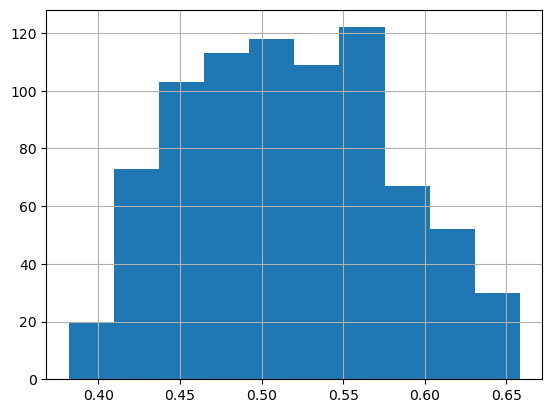

In [371]:
pd.Series(model.predict_proba(df_train[feat_vars])[:, 1]).hist()

<Axes: >

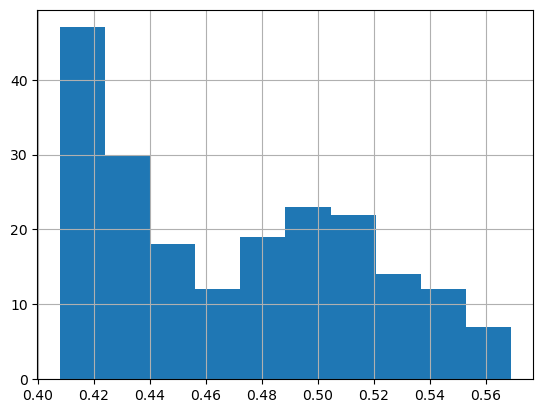

In [370]:
pd.Series(model.predict_proba(df_test[feat_vars])[:, 1]).hist()

In [359]:
outcome_var='binary_mean_rise_90_forward'
Train AUC: 0.7958144796380091
Train AUC_PR: 0.8019247861388439
Test AUC: 0.6210420417240284
Test AUC_PR: 0.8053373289565497
Best parameters found: {'max_depth': 18, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'min_samples_split': 8, 'n_estimators': 300}

,feature,gain,prop_gain,rank_gain
0,prop_sum_following_4_calls_8weeks_ago,0.043333,0.043333,1.0
1,sale_sum_next_4_calls_24weeks_ago,0.036667,0.036667,2.0
2,prop_sum_following_4_calls_12weeks_ago,0.033333,0.033333,3.5
3,net_sum_next_4_calls_pct_share_24week,0.033333,0.033333,3.5
4,sale_total_calls_pct_share_24week,0.030000,0.030000,6.0
...,...,...,...,...
671,purchase_calls_month_4_24weeks_ago,0.000000,0.000000,394.0
672,prop_sum_next_3_calls_pct_share_4week,0.000000,0.000000,394.0
673,sale_calls_month_5_pct_share_4week,0.000000,0.000000,394.0
674,prop_total_calls_pct_share_8week,0.000000,0.000000,394.0


In [ ]:
Train AUC: 0.7268369622811233
Train AUC_PR: 0.7300607518912272
Test AUC: 0.5350859656137545
Test AUC_PR: 0.6773017828555866
Best parameters found: {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'min_samples_split': 12, 'n_estimators': 300}

In [ ]:
outcome_var='binary_mean_rise_120_forward',
Train AUC: 0.823245667936586
Train AUC_PR: 0.8320854634255619
Test AUC: 0.6071205821205822
Test AUC_PR: 0.7979478118496164
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'min_samples_split': 3, 'n_estimators': 350}

In [ ]:
{'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 2, 'min_samples_split': 10, 'n_estimators': 300}

In [351]:
from hyperopt import hp, STATUS_OK, tpe, atpe, fmin, Trials, SparkTrials, pyll
sys.path.insert(0, 'libraries')
from model_builder import OptimalModel, ModelBuilder

space_lgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 5, 150, 5)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 2, 16, 1)),
    # 'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 2, 150, 1)),
    'min_child_samples': pyll.scope.int(hp.choice('min_child_samples', [3, 5, 10, 20, 30, 40, 50, 60, 70, 80])),
    'reg_alpha': hp.choice('reg_alpha', [0, 0.001, 0.01, 0.1, 0.2]),
    'reg_lambda': hp.choice('reg_lambda', [0, 0.001, 0.01, 0.1, 0.2]),
    # 'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01),
    # 'outcome_var': hp.choice('outcome_var', vars)
#     'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
#     'subsample': hp.uniform('subsample', 0.1, 1.0),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    #,'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

opt = OptimalModel(df_train=df_train,
                   df_test=df_test,
                   cols=feat_vars, 
                   outcome_var='binary_mean_rise_30_forward',
                   model_type='lgb', 
                   evals=100, 
                   opt_lib='hp', 
                   search_space=space_lgb, 
                   how_to_tune='cross_val', 
                   eval_metric='auc',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='classification', 
                   k=10,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

Performing model optimisation
100%|██████| 100/100 [02:22<00:00,  1.43s/trial, best loss: -0.5496287107307827]
100 rounds of hp cross_val optimisation ran in 142.705 seconds
LGB built in 0.386 seconds
Train AUC: 0.8941597969267926
Train AUC_PR: 0.9005826163498178
Test AUC: 0.4384246301479408
Test AUC_PR: 0.5678052209364366
Best parameters found: {'boosting_type': 'dart', 'learning_rate': 0.010080620506976964, 'max_depth': 6, 'min_child_samples': 60, 'n_estimators': 45, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
Cross validation scores: [0.55896806 0.5027439  0.48382173 0.56392857 0.64068323 0.63366013
 0.65636475 0.42951128 0.52468729 0.50191816]


In [ ]:
{'boosting_type': 'dart', 'learning_rate': 0.01756266955307935, 'max_depth': 8, 'min_child_samples': 30, 'n_estimators': 5, 'reg_alpha': 0.2, 'reg_lambda': 0}

In [190]:
importance

,feature,gain,splits,prop_gain,prop_splits,rank_splits,rank_gain
0,prop_sum_following_4_calls_12weeks_ago,44847.679977,12,0.069678,0.013086,6.0,1.0
1,sale_total_calls_pct_share_24week,33176.612740,11,0.051545,0.011996,8.5,2.0
2,sale_total_calls_pct_share_52week,26121.972900,8,0.040585,0.008724,21.0,3.0
3,prop_total_calls_52weeks_ago,22821.973091,9,0.035458,0.009815,15.5,4.0
4,purchase_calls_month_5_8weeks_ago,22412.080551,10,0.034821,0.010905,12.0,5.0
...,...,...,...,...,...,...,...
671,sale_calls_month_4_pct_share_24week,0.000000,0,0.000000,0.000000,500.0,500.0
672,purchase_sum_next_2_calls_pct_share_24week,0.000000,0,0.000000,0.000000,500.0,500.0
673,sale_total_calls_8weeks_ago,0.000000,0,0.000000,0.000000,500.0,500.0
674,purchase_sum_following_4_calls_4weeks_ago,0.000000,0,0.000000,0.000000,500.0,500.0


In [209]:
from hyperopt import hp, STATUS_OK, tpe, atpe, fmin, Trials, SparkTrials, pyll
sys.path.insert(0, 'libraries')
from model_builder import OptimalModel, ModelBuilder

space_logistic_regularised = {
  'penalty':hp.choice('penalty', ['l1']),
  'solver':hp.choice('solver', ['saga', 'liblinear']),  
  'C': hp.quniform('C', 0.01, 1, 0.01),
  'cutoff': hp.quniform('cutoff', 0.01, 1, 0.01)
}

space_lasso = {
  'alpha': hp.uniform('alpha', 0, 1),
  'max_iter': hp.choice('max_iter', [100000]) 
}

opt = OptimalModel(df_train=df_train,
                   df_test=df_test,
                   cols=feat_vars, 
                   outcome_var='value_delta_mean_120_forward',
                   model_type='lasso', 
                   evals=10, 
                   opt_lib='hp', 
                   search_space=space_lasso, 
                   how_to_tune='cross_val_standardised', 
                   eval_metric='explained_variance',
                   n_jobs=-1, 
                   seed=123, 
                   outcome_type='regression', 
                   k=4,
                   stratify_kfold=False)

model, params, trials, importance, errors, cv_scores = opt.build_optimal_model()

Performing model optimisation
100%|█████████| 10/10 [00:04<00:00,  2.05trial/s, best loss: 12.609805715310426]
10 rounds of hp cross_val_standardised optimisation ran in 4.901 seconds
Train error: 6.946360911482938
Test error: 18.182277119912836
Train explained variance: 0.6823131427147981
Test explained variance: -1.6138386208079245
Train WAPE: -280.84926680041355
Test WAPE: 8.565997985388924
Best parameters found: {'alpha': 0.9647172147598274, 'max_iter': 100000}
Cross validation scores: [ -73.23517887 -472.75996663  -50.69557625 -169.47719411]


In [110]:
importance

,feature,gain,splits,prop_gain,prop_splits,rank_splits,rank_gain
0,sale_total_calls_pct_share_52week,111551.780273,66,0.329652,0.212219,1.0,1.0
1,sale_total_calls_last10_total,74711.289917,55,0.220783,0.176849,2.0,2.0
2,net_sum_next_4_calls_pct_share_12week,30486.532043,23,0.090092,0.073955,4.0,3.0
3,prop_total_calls_24weeks_ago,28431.669922,20,0.084020,0.064309,5.0,4.0
4,prop_calls_month_1_8weeks_ago,28267.877960,50,0.083536,0.160772,3.0,5.0
...,...,...,...,...,...,...,...
690,purchase_calls_month_4_pct_share_24week,0.000000,0,0.000000,0.000000,361.0,361.0
691,purchase_calls_month_4_pct_share_52week,0.000000,0,0.000000,0.000000,361.0,361.0
692,purchase_calls_month_5_1weeks_ago,0.000000,0,0.000000,0.000000,361.0,361.0
693,purchase_calls_month_5_pct_share_1week,0.000000,0,0.000000,0.000000,361.0,361.0


Explained variance: 0.366359772828868


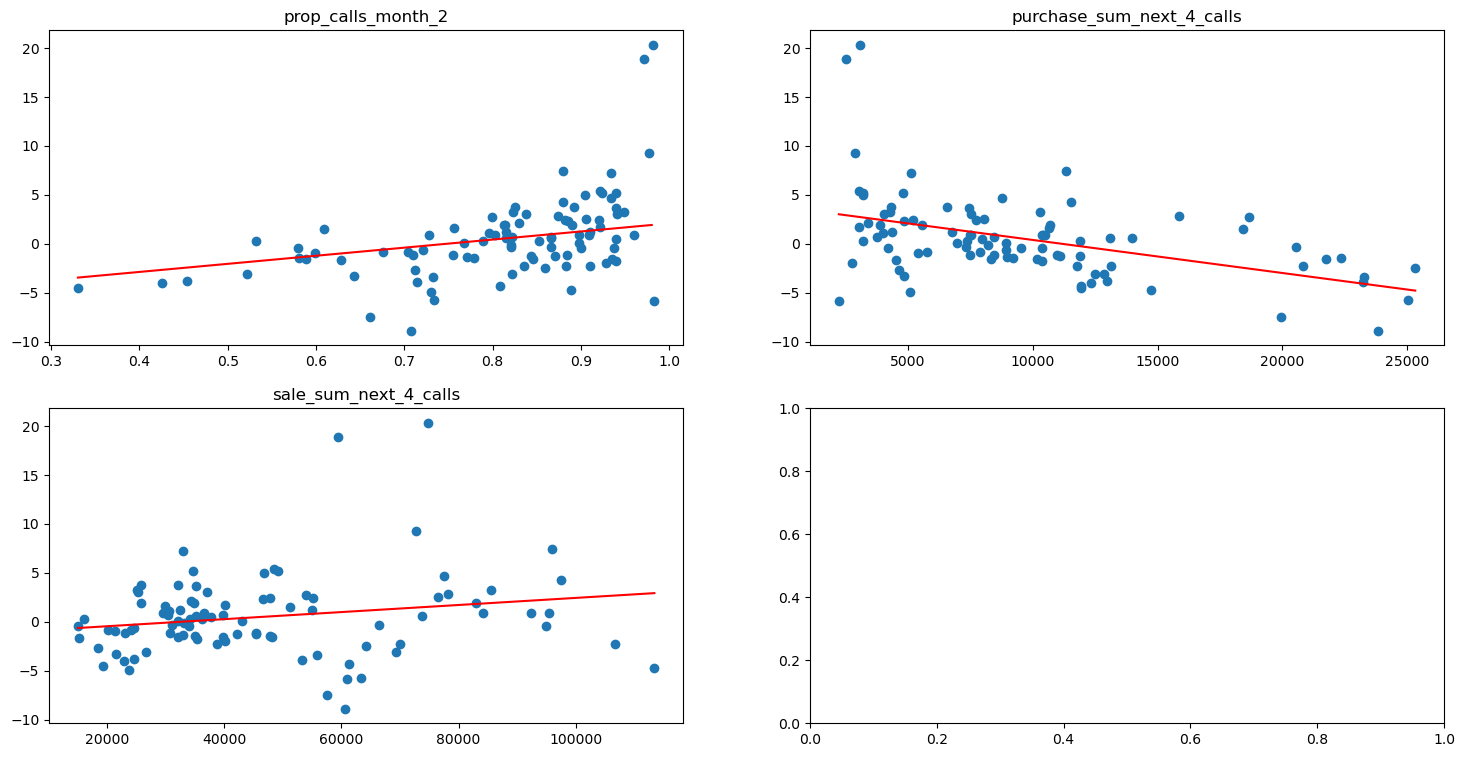

In [168]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, explained_variance_score

class LinearRegressionModel():
    
    def __init__(self, df, month=None):
        
        self.df = df
        self.month = month
        
        if self.month is not None:
            self.df = self.df[self.df['report_month'] == self.month].copy()
    
    def data_prep(self, df, features, outcome):

        df = df[features + [outcome]].dropna()
        
        # need to add standardisation
        
        return df
    
    def fit(self, features, outcome):
        
        if isinstance(features, str):
            features = [features]
            
        self.features = features
        self.outcome = outcome
        
        # self.df = self.data_prep(self.df, features, outcome)
        
        self.model = LinearRegression()
        self.model.fit(self.df_train[features], self.df_train[outcome])

        self.df['pred'] = self.model.predict(self.df[features])

        self.explained_variance = explained_variance_score(self.df[outcome], self.model.predict(self.df[features]))
        
        print(f'Explained variance: {self.explained_variance}')
    
    def plot(self, n_per_row=2, figsize=(18, 9)):
        
        n_feats = len(self.features)
        n_rows = math.ceil(n_feats / n_per_row)

        _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)

        if n_feats > 1:
            axes = axs.flatten()
        else:
            axes = axs

        for feat, ax in zip(self.features, axes):

            other_features = [x for x in self.features if x != feat]
            df_preds = pd.DataFrame({feat:np.arange(self.df[feat].min(), self.df[feat].max(), 0.01)})

            for constant_feat in other_features:
                df_preds[constant_feat] = self.df[constant_feat].mean()

            df_preds['pred'] = self.model.predict(df_preds[self.features])

            ax.scatter(self.df[feat], self.df[self.outcome])
            ax.plot(df_preds[feat], df_preds['pred'], c='red')
            ax.set_title(f'{feat}')

model = LinearRegressionModel(df_mset, 2)
model.fit(features=['prop_calls_month_2', 
                    'purchase_sum_next_4_calls', 
                    'sale_sum_next_4_calls'], 
          outcome='value_delta_mean_30_forward')
model.plot()

Explained variance: 0.38663091360973034


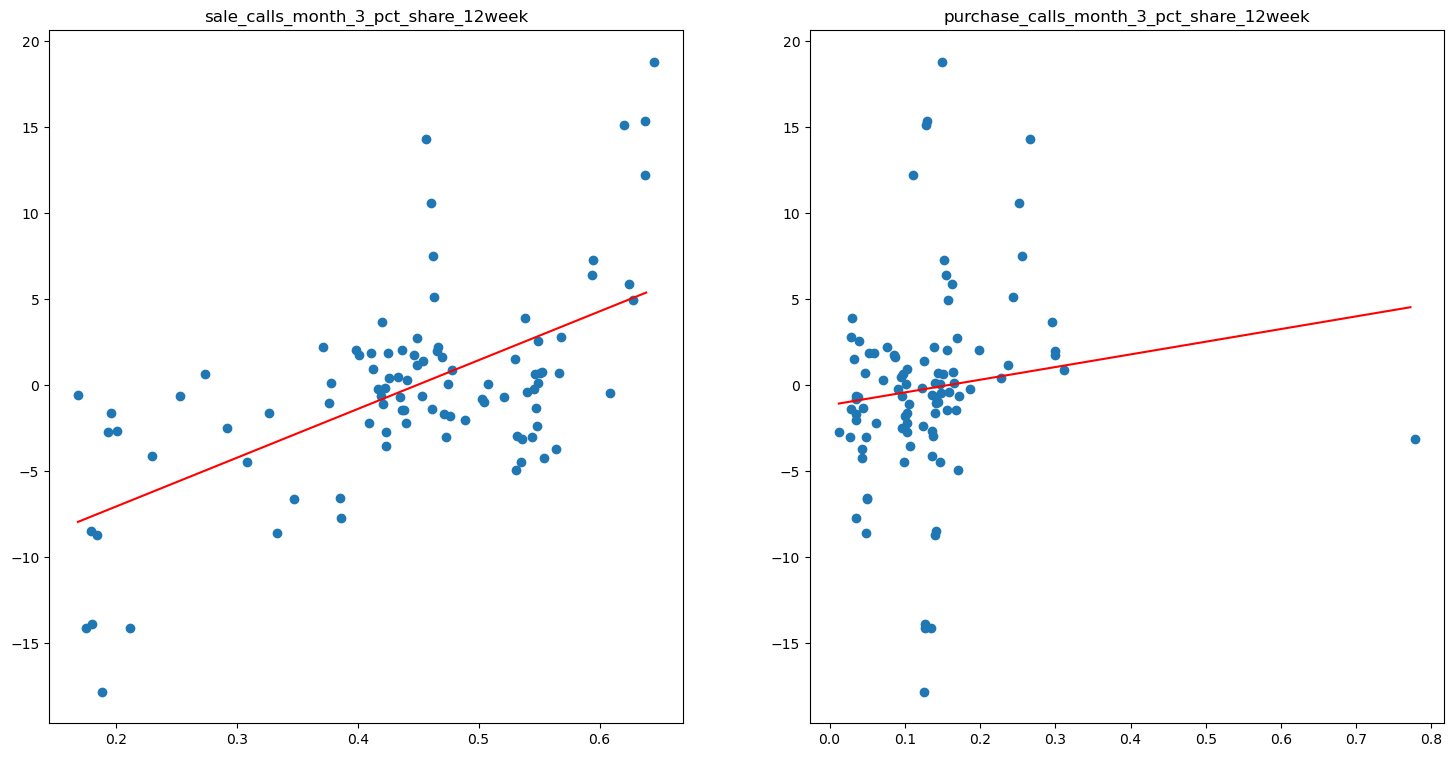

In [169]:
model = LinearRegressionModel(df_mset, 9)
model.fit(features=['sale_calls_month_3_pct_share_12week', 'purchase_calls_month_3_pct_share_12week'], 
          outcome='value_delta_mean_30_forward')
model.plot()

Explained variance: 0.05799474080889211


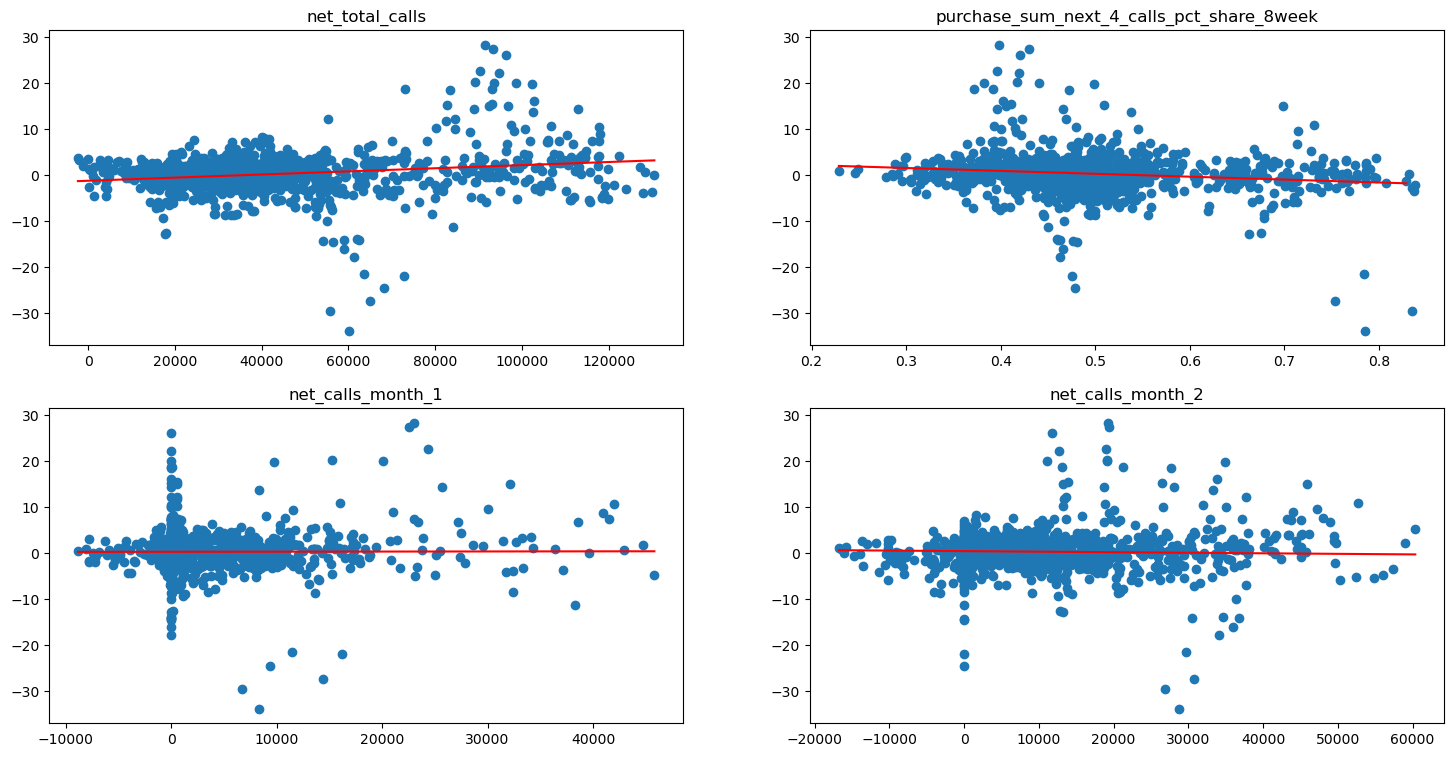

In [175]:
model = LinearRegressionModel(df_mset)
model.fit(features=['net_total_calls', 'purchase_sum_next_4_calls_pct_share_8week', 'net_calls_month_1', 'net_calls_month_2'], 
          outcome='value_delta_mean_30_forward')
model.plot()

array([[<Axes: title={'center': 'value_delta_mean_30_forward'}>]],
      dtype=object)

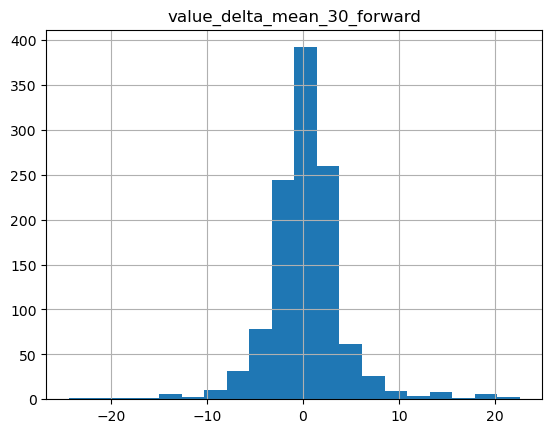

In [292]:
df_mset[(df_mset[outcome]>-25) & (df_mset[outcome]<25)].hist(outcome, bins=20)

In [302]:
def define_traffic_light_bounds(df, bounds):
    
    query = "df['traffic_light'] = "
    
    for i, boundary in enumerate(bounds):
        query = query + f"np.where(df['pred'] < {boundary}, {i}, \n"
    
    query = query + f"{i+1}{(i+1)*')'}"
    
    print(query)
    
    exec(query)
    
define_traffic_light_bounds(df, [-8, -5, 0, 5, 8])

df['traffic_light'] = np.where(df['pred'] < -8, 0, 
np.where(df['pred'] < -5, 1, 
np.where(df['pred'] < 0, 2, 
np.where(df['pred'] < 5, 3, 
np.where(df['pred'] < 8, 4, 
5)))))


In [303]:
df['traffic_light'].value_counts().sort_values()

0     2
4     4
1     7
2    36
3    47
Name: traffic_light, dtype: int64

array([[<Axes: title={'center': 'pred'}>]], dtype=object)

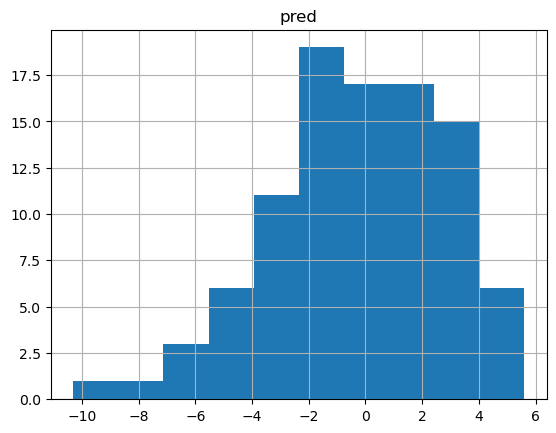

In [287]:
df.hist('pred')